# Data Loading and precoess

 This notebook begins with setting up the necessary environment and importing libraries for single-cell RNA-seq data analysis, machine learning, and visualization. We use the Scanpy library, a popular toolkit for analyzing single-cell data, alongside scikit-learn, XGBoost, and other essential Python libraries. The configuration includes setting verbosity levels for logging and figure parameters to ensure consistent and informative output throughout the analysis.

In [ ]:
# Install and import required libraries
!pip install scanpy

import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
from sklearn.datasets import load_svmlight_file
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.linear_model import LogisticRegression
from xgboost import XGBRegressor
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
import anndata

# Scanpy settings
sc.settings.verbosity = 3  # Set verbosity level: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()  # Print Scanpy version information and other settings
sc.settings.set_figure_params(dpi=80, facecolor='white')  # Set default figure parameters for better visualization


## Step 1: Load and Prepare Individual Datasets
This section handles the loading and preparation of male and female single-cell RNA-seq datasets:

1. **Load Data Matrices**: 
   - The male and female datasets are loaded from `male.mtx` and `female.mtx` respectively using `scanpy.read_mtx()` and transposed to align rows with cells and columns with genes.
2. **Load Gene Annotations**: 
   - Gene annotations are read from `male.tsv` and `female.tsv` using `pandas.read_csv()`, with each file containing gene information.
3. **Assign Gene Names**: 
   - The gene names for both datasets are set using the second column of the annotations.
4. **Ensure Uniqueness**: 
   - Gene names are made unique using `var_names_make_unique()` to avoid conflicts in the datasets.

 

In [2]:
# Load and transpose data
male_data = sc.read_mtx('male.mtx').T
female_data = sc.read_mtx('female.mtx').T

# Load annotations
male_annotations = pd.read_csv('male.tsv', sep='\t', header=None)
female_annotations = pd.read_csv('female.tsv', sep='\t', header=None)

# Set gene names
male_data.var_names = male_annotations[1].values
female_data.var_names = female_annotations[1].values

# Ensure gene names are unique
male_data.var_names_make_unique()
female_data.var_names_make_unique()



## Step 2: Find and Align Common Genes
This section aligns the male and female datasets by their shared gene space:

1. **Identify Common Genes**: 
   - The intersection of gene names between the male and female datasets is calculated to ensure consistency in features.
   - A count of the common genes is printed for reference.
2. **Subset to Common Genes**: 
   - Both datasets are filtered to retain only these common genes, harmonizing their feature spaces for downstream analysis.

 

In [3]:
# Find common genes
common_genes = male_data.var_names.intersection(female_data.var_names)
print(f"Number of common genes: {len(common_genes)}")

# Subset to common genes
male_data = male_data[:, common_genes]
female_data = female_data[:, common_genes]


Number of common genes: 32285



## Step 3: Assign Labels and Merge Datasets
This section labels cells, adds metadata, and merges the datasets into a single object:

1. **Assign Cell IDs and Labels**: 
   - Unique IDs (`male_cell_x` or `female_cell_x`) are assigned to the cells in each dataset.
   - A metadata label `gender` is added to distinguish cells as `male` or `female`.
2. **Concatenate Datasets**: 
   - The male and female datasets are combined into a single `AnnData` object using `anndata.concat()`.
   - A `batch` label is included to indicate dataset origin.
   - The intersection of genes is retained during concatenation (`join='inner'`).
3. **Ensure Uniqueness**: 
   - Gene names in the combined dataset are made unique to prevent duplication issues.







In [4]:
# Assign cell IDs and labels
male_data.obs_names = [f"male_cell_{i}" for i in range(male_data.n_obs)]
female_data.obs_names = [f"female_cell_{i}" for i in range(female_data.n_obs)]
male_data.obs['gender'] = 'male'
female_data.obs['gender'] = 'female'

# Concatenate datasets
adata = anndata.concat(
    [male_data, female_data],
    join='inner',
    label='batch',
    keys=['male', 'female'],
    index_unique=None
)

# Ensure gene names are unique
adata.var_names_make_unique()


## Step 4: Quality Control (QC) Metrics and Visualization

This step performs quality control checks to ensure the dataset is suitable for downstream analysis:

1. **Mitochondrial Gene Identification**:
   - Mitochondrial genes are detected by checking if their names start with `mt-` or `MT-`. These genes are flagged in the dataset to assess the quality of cellular data.

2. **QC Metric Calculation**:
   - Key metrics such as the percentage of counts from mitochondrial genes (`pct_counts_mt`), the total transcript counts, and the number of genes detected per cell (`n_genes_by_counts`) are calculated. These metrics help identify low-quality cells, such as those with high mitochondrial content or low gene detection rates.

3. **Visualization**:
   - The top 20 most expressed genes are visualized to evaluate general gene expression patterns.
   - Violin plots are generated to examine the distributions of quality metrics across cells, and scatter plots provide insights into potential relationships between metrics, such as how mitochondrial content correlates with total counts or gene detection rates.


normalizing counts per cell
    finished (0:00:00)


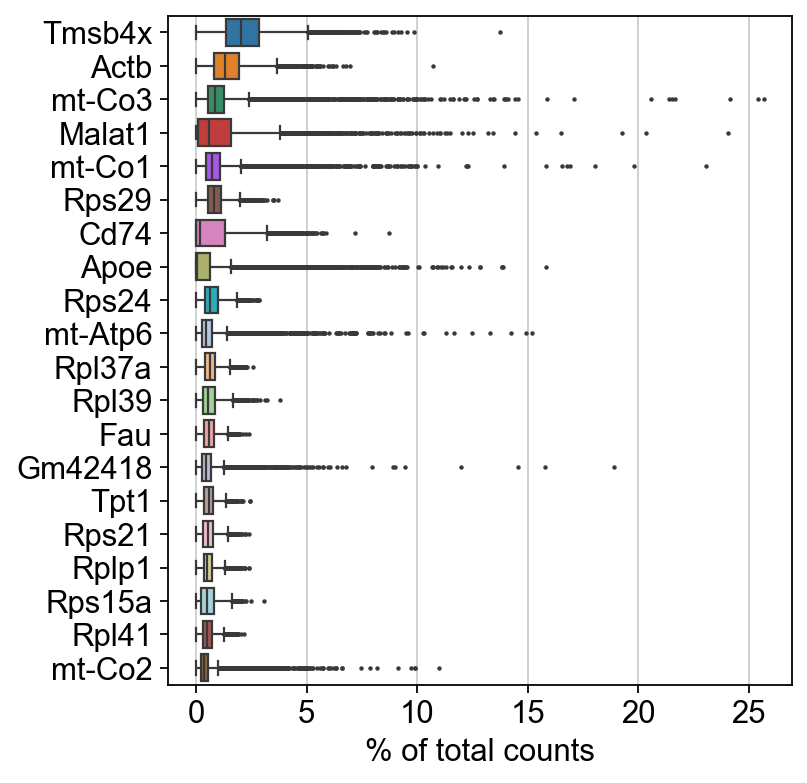

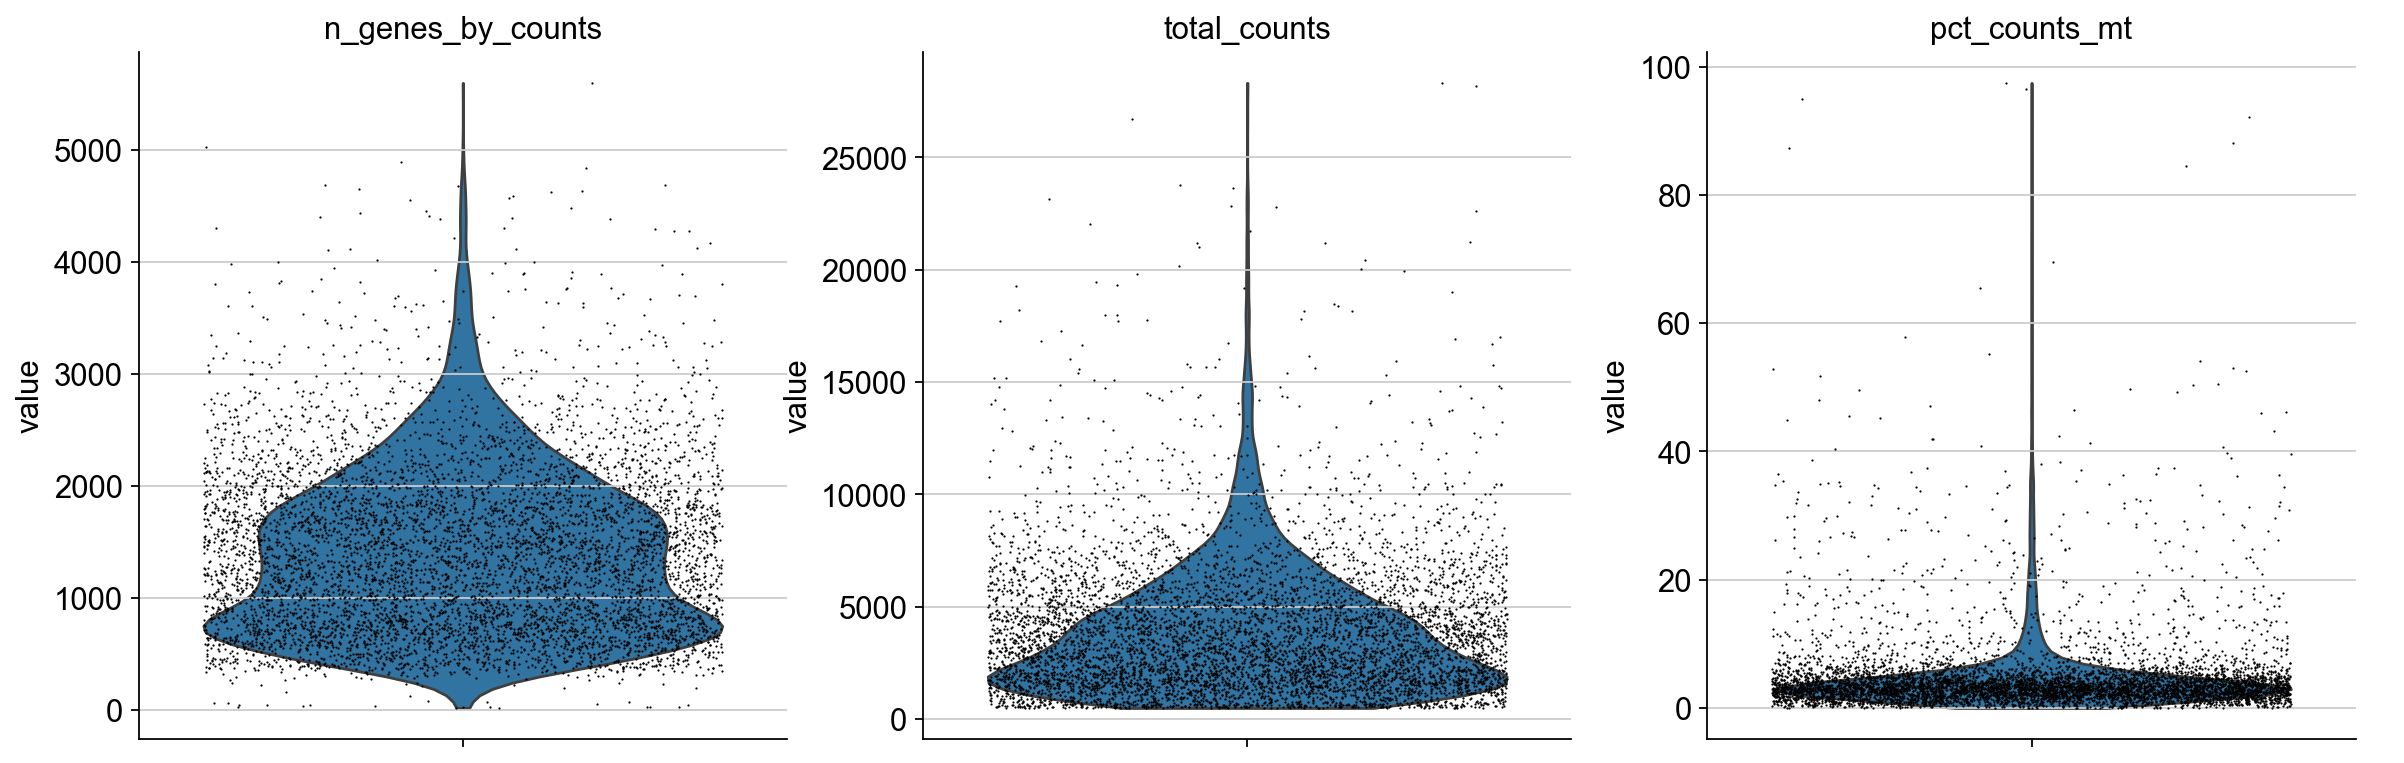

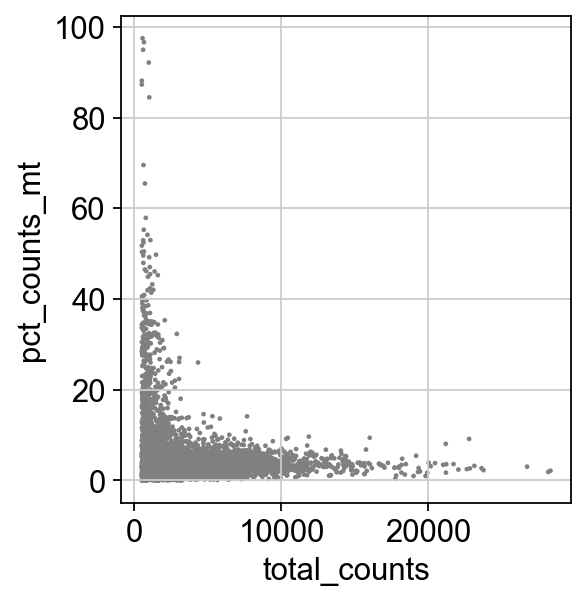

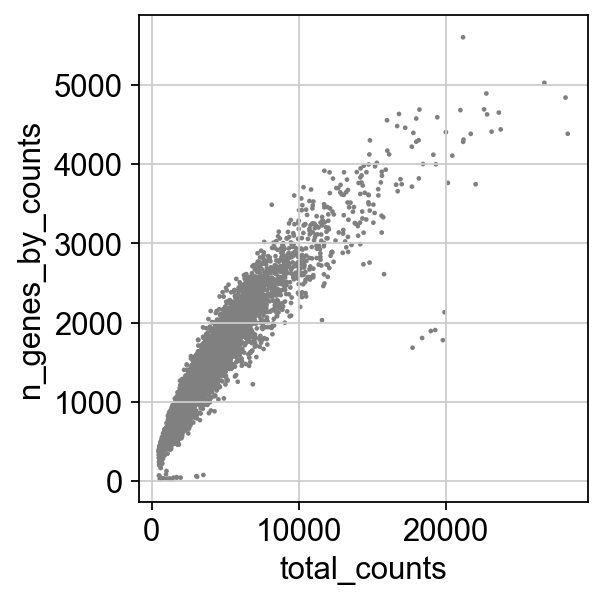

In [5]:
# Identify mitochondrial genes
adata.var['mt'] = adata.var_names.str.startswith(('mt-', 'MT-'))

# Calculate QC metrics
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], inplace=True)

# Plot highest expressed genes
sc.settings.set_figure_params(dpi=80, facecolor='white')
sc.pl.highest_expr_genes(adata, n_top=20)

# Generate QC plots
sc.pl.violin(
    adata,
    ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
    jitter=0.4,
    multi_panel=True
)
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')


## Step 5: Data Filtering and Transformation

This step focuses on preparing the data for analysis by filtering low-quality features, applying transformations, and identifying key variables:

1. **Data Format Conversion**:
   - If the dataset's gene expression matrix (`adata.X`) is in a sparse format, it is converted to a dense array. This ensures compatibility with downstream operations that require dense matrices.

2. **Gene Filtering**:
   - Genes expressed in fewer than three cells are removed from the dataset. This step eliminates low-quality features that are unlikely to provide meaningful biological insights.

3. **Logarithmic Transformation**:
   - A log transformation is applied to the gene expression data to stabilize variance and reduce the impact of outliers. This transformation is essential for many downstream analyses that assume normalized data distributions.

4. **Highly Variable Gene Identification**:
   - Genes that show significant variability across cells are identified using specified thresholds for mean expression (`min_mean=0.0125`, `max_mean=3`) and dispersion (`min_disp=0.5`). These highly variable genes are critical for downstream dimensionality reduction and clustering.
   - A visualization of highly variable genes is generated to confirm the selection.

5. **Constructing a DataFrame**:
   - The dense gene expression matrix is converted into a pandas DataFrame, with rows representing cells and columns representing genes.
   - A column for the `gender` metadata is added to the DataFrame to facilitate downstream analysis that incorporates cell annotations.


filtered out 15132 genes that are detected in less than 3 cells
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


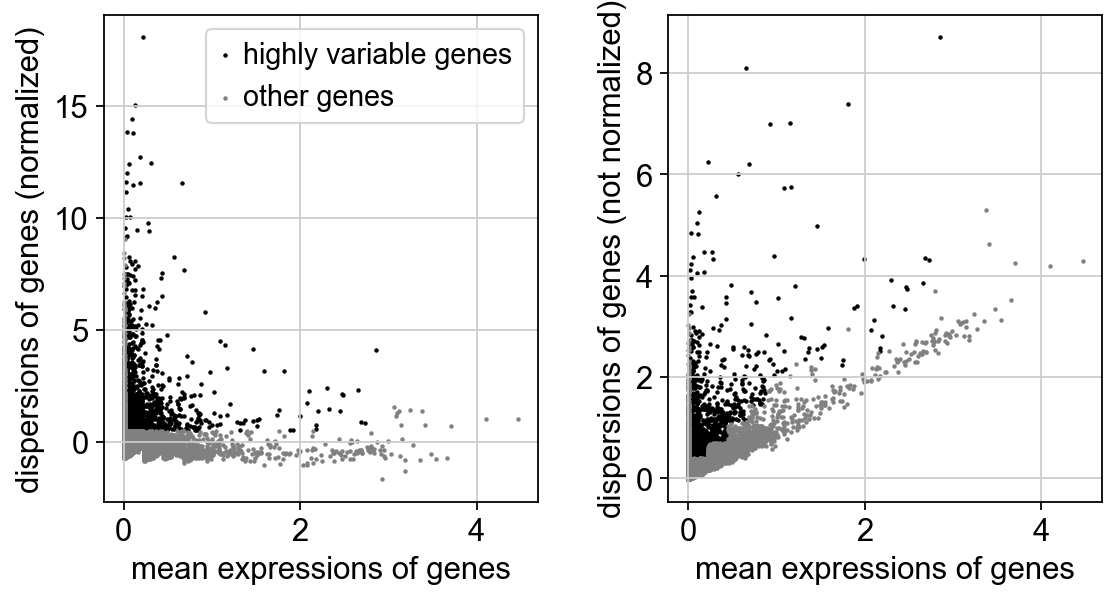

adata.X shape: (6648, 17153)
X_dense shape: (6648, 17153)
adata.obs_names length: 6648
adata.var_names length: 17153


In [6]:
from scipy.sparse import issparse
import scanpy as sc
import pandas as pd

# First, apply gene filtering
sc.pp.filter_genes(adata, min_cells=3)

# Log-transform the data
sc.pp.log1p(adata)

# Identify highly variable genes and plot
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pl.highly_variable_genes(adata)

# Convert the filtered and transformed data matrix to dense format
if issparse(adata.X):
    X_dense = adata.X.toarray()
else:
    X_dense = adata.X

# Confirm alignment of shapes before creating DataFrame
print(f"adata.X shape: {adata.X.shape}")
print(f"X_dense shape: {X_dense.shape}")
print(f"adata.obs_names length: {len(adata.obs_names)}")
print(f"adata.var_names length: {len(adata.var_names)}")

# Create the DataFrame
rc = pd.DataFrame(X_dense, index=adata.obs_names, columns=adata.var_names)
rc['gender'] = adata.obs['gender'].values

In [7]:
rc

,Sox17,Mrpl15,Lypla1,Tcea1,Gm16041,Atp6v1h,Rb1cc1,4732440D04Rik,St18,Pcmtd1,...,AC168977.1,CAAA01118383.1,AC132444.1,AC132444.5,Csprs,Vamp7,Tmlhe,CAAA01147332.1,AC149090.1,gender
male_cell_0,0.0,0.000000,0.693147,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,1.098612,male
male_cell_1,0.0,0.000000,0.000000,1.098612,0.0,0.000000,0.693147,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.693147,male
male_cell_2,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,male
male_cell_3,0.0,0.000000,0.000000,0.693147,0.0,0.000000,0.000000,0.0,0.0,0.693147,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.693147,male
male_cell_4,0.0,0.693147,0.000000,0.693147,0.0,0.693147,0.693147,0.0,0.0,0.000000,...,0.0,0.693147,0.0,0.0,0.0,0.000000,0.0,0.0,0.693147,male
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
female_cell_3958,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.693147,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,female
female_cell_3959,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,female
female_cell_3960,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.693147,...,0.0,0.000000,0.0,0.0,0.0,0.693147,0.0,0.0,0.000000,female
female_cell_3961,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.693147,0.0,0.0,0.693147,...,0.0,0.693147,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,female


# Training and Testing Model


This section implements a machine learning pipeline to classify gender based on selected gene expression features. The pipeline is structured into the following key steps:
- Importing required libraries.
- Preparing the dataset by selecting features and encoding the target variable.
- Initializing multiple machine learning models.
- Performing cross-validation to evaluate model performance.
- Computing and visualizing evaluation metrics such as AUROC and AUPRC.

---

## Detailed Steps

### 1. **Import Necessary Libraries**
The code imports essential libraries to handle various tasks:
- **Data Handling**: `pandas`, `numpy` for data manipulation and numerical operations.
- **Model Training**: Includes `LogisticRegression`, `SVC`, `XGBClassifier`, and `RandomForestClassifier`.
- **Preprocessing**: Utilizes `StandardScaler` to standardize features and `LabelEncoder` to encode categorical labels.
- **Cross-Validation**: Uses `KFold` to split data for training and validation.
- **Evaluation**: Implements metrics such as accuracy, precision, recall, F1-score, AUROC, and AUPRC.
- **Visualization**: Leverages `matplotlib` and `seaborn` for performance comparison plots.

---

### 2. **Prepare Dataset**
- **Load Dataset**: 
  Assumes the dataset `rc` is preprocessed or loaded from a file (e.g., `processed_data.csv`).
- **Verify Columns**:
  Prints column names of `rc` to confirm the presence of necessary features and the target variable.
- **Feature Extraction**:
  Selects specific gene expression features (e.g., `'Rpl35', 'Uty', 'Kdm5d'`) for model training.
- **Target Encoding**:
  Encodes the target variable (`gender`) into numerical values using `LabelEncoder` for binary classification tasks.

---

### 3. **Initialize Models**
Four machine learning models are initialized with carefully chosen hyperparameters:
- **Logistic Regression**: Configured with a maximum of 1000 iterations for convergence.
- **Support Vector Classifier (SVC)**: Uses a linear kernel and enables probability estimation.
- **XGBoost Classifier**: Configured with 100 estimators, a learning rate of 0.05, and a maximum depth of 10.
- **Random Forest Classifier**: Configured with a maximum depth of 100 to control overfitting.

---

### 4. **Cross-Validation**
- A 5-fold cross-validation scheme is applied to evaluate each model's performance.
- For each fold:
  1. Data is split into training and validation subsets.
  2. Features are scaled using `StandardScaler` to ensure consistency.
  3. Models are trained on the training data and validated on the validation set.
  4. Predictions are evaluated using the following metrics:
     - **Accuracy**: Measures the overall correctness.
     - **Precision and Recall**: Focus on the positive class's performance.
     - **F1-Score**: Provides a harmonic mean of precision and recall.
     - **AUROC and AUPRC**: Evaluate the quality of probability-based predictions.
- Probability scores are computed using `predict_proba` or `decision_function` if available; if not, appropriate warnings are issued.

---

### 5. **Store Results**
- Metrics are averaged across all folds and stored for each model, providing a summary of performance across multiple iterations.

---

### 6. **Visualize Performance**
- **Bar Plots**:
  - AUROC and AUPRC metrics are visualized for each model using `seaborn.barplot`.
  - These plots allow for a side-by-side comparison of models, aiding in identifying the most effective classifier for the dataset.

---
 


Performing cross-validation for LogisticRegression...

Performing cross-validation for SVC...

Performing cross-validation for XGBClassifier...

Performing cross-validation for RandomForestClassifier...

LogisticRegression Cross-Validation Results:
Accuracy: 0.8988
Precision: 0.8462
Recall: 0.9160
F1_score: 0.8796
Auroc: 0.9682
Auprc: 0.9515

SVC Cross-Validation Results:
Accuracy: 0.9001
Precision: 0.8386
Recall: 0.9325
F1_score: 0.8830
Auroc: 0.9674
Auprc: 0.9490

XGBClassifier Cross-Validation Results:
Accuracy: 0.8943
Precision: 0.8366
Recall: 0.9180
F1_score: 0.8753
Auroc: 0.9674
Auprc: 0.9500

RandomForestClassifier Cross-Validation Results:
Accuracy: 0.8914
Precision: 0.8457
Recall: 0.8946
F1_score: 0.8694
Auroc: 0.9602
Auprc: 0.9329


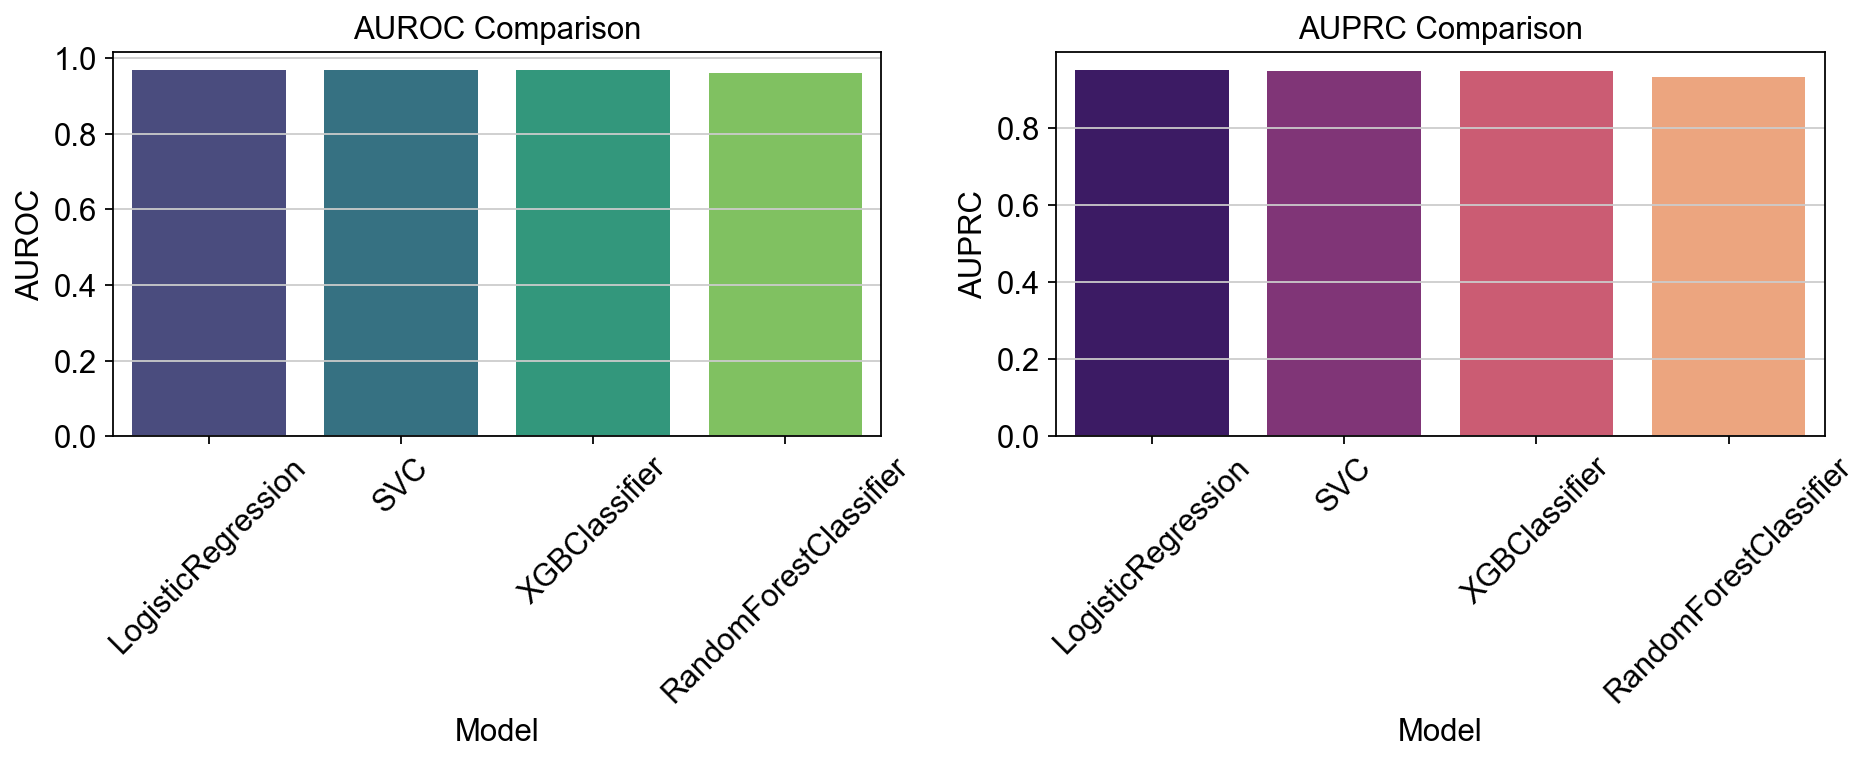

In [8]:
# Import necessary libraries
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import KFold
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, average_precision_score
)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load your dataset
# Ensure that 'rc' is correctly loaded with the necessary columns
# If 'rc' was created in previous code, you need to save it or run the preprocessing code here
# For example, if you saved 'rc' to a CSV file:
# rc = pd.read_csv('processed_data.csv')

# If 'rc' is already in memory, proceed to the next steps

 

# Extracting the necessary columns for training
columns_to_extract = [
    'Rpl35', 'Rps27rt', 'Rpl9-ps6', 'Rps27', 'Uba52', 'Lars2',
    'Gm42418', 'Uty', 'Kdm5d', 'Eif2s3y', 'Ddx3y', 'Xist'
]
X = rc[columns_to_extract]

# Encode the target variable
le = LabelEncoder()
y = le.fit_transform(rc['gender'])  # Assuming 'gender' is the target variable

# Initialize models
models = [
    LogisticRegression(max_iter=1000, random_state=551),
    SVC(kernel='linear', probability=True, random_state=551),
    XGBClassifier(
        eval_metric='logloss',
        n_estimators=100,
        learning_rate=0.05,
        max_depth=10,
        random_state=551
    ),
    RandomForestClassifier(max_depth=100, random_state=41)
]

# Cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=551)
cv_results = {}

for model in models:
    model_name = type(model).__name__
    print(f"\nPerforming cross-validation for {model_name}...")
    
    metrics = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1_score': [],
        'auroc': [],
        'auprc': []
    }
    
    for train_index, val_index in kf.split(X):
        # Split data into training and validation sets
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y[train_index], y[val_index]  # Index y as a NumPy array
        
        # Scale data within each fold
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_val_scaled = scaler.transform(X_val)
        
        # Train model
        model.fit(X_train_scaled, y_train)
        
        # Make predictions
        y_pred = model.predict(X_val_scaled)
        
        # Evaluate metrics
        metrics['accuracy'].append(accuracy_score(y_val, y_pred))
        metrics['precision'].append(precision_score(y_val, y_pred))
        metrics['recall'].append(recall_score(y_val, y_pred))
        metrics['f1_score'].append(f1_score(y_val, y_pred))
        
        # Compute predicted probabilities for AUROC and AUPRC
        if hasattr(model, "predict_proba"):
            y_proba = model.predict_proba(X_val_scaled)[:, 1]
        elif hasattr(model, "decision_function"):
            # For models like SVM without predict_proba but with decision_function
            y_scores = model.decision_function(X_val_scaled)
            y_proba = (y_scores - y_scores.min()) / (y_scores.max() - y_scores.min())
        else:
            # If neither is available, skip AUROC and AUPRC computation
            y_proba = None
            print(f"Model {model_name} does not support probability estimates.")
        
        if y_proba is not None:
            # Evaluate AUROC and AUPRC
            metrics['auroc'].append(roc_auc_score(y_val, y_proba))
            metrics['auprc'].append(average_precision_score(y_val, y_proba))
        
    # Store average metrics for the model
    cv_results[model_name] = {metric: np.mean(values) for metric, values in metrics.items()}
    
# Display cross-validation results for each model
for model_name, metrics in cv_results.items():
    print(f"\n{model_name} Cross-Validation Results:")
    for metric, value in metrics.items():
        print(f"{metric.capitalize()}: {value:.4f}")
        

# Prepare data for plotting
metrics_to_plot = ['auroc', 'auprc']
plot_data = []

# Reshape data for Seaborn's new API
for model_name, metrics in cv_results.items():
    for metric in metrics_to_plot:
        plot_data.append({
            'Model': model_name,
            'Metric Value': metrics.get(metric, 0),
            'Metric Type': metric.upper()
        })

plot_df = pd.DataFrame(plot_data)

# Create bar plots for AUROC and AUPRC
plt.figure(figsize=(12, 5))

# AUROC bar plot
plt.subplot(1, 2, 1)
sns.barplot(data=plot_df[plot_df['Metric Type'] == 'AUROC'],
            x='Model',
            y='Metric Value',
            hue='Model',
            legend=False,
            palette='viridis')
plt.title('AUROC Comparison')
plt.xlabel('Model')
plt.ylabel('AUROC')
plt.xticks(rotation=45)

# AUPRC bar plot
plt.subplot(1, 2, 2)
sns.barplot(data=plot_df[plot_df['Metric Type'] == 'AUPRC'],
            x='Model',
            y='Metric Value',
            hue='Model',
            legend=False,
            palette='magma')
plt.title('AUPRC Comparison')
plt.xlabel('Model')
plt.ylabel('AUPRC')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


# Working with Human Data

This section provides guidance on two options for working with human single-cell RNA-seq data for sex prediction:

## Option 1: Use Preprocessed Human Data

The simplest approach is to use the preprocessed human data file that's already prepared for you:


In [ ]:
# Load preprocessed human data
human_adata = sc.read_h5ad('/Users/haley/Downloads/CellSexID-main/human_data.h5ad')

# The data is already QC filtered and normalized
print(f"Loaded human data: {human_adata.n_obs} cells × {human_adata.n_vars} genes")
print(f"Available metadata: {list(human_adata.obs.columns)}")
print(f"Sex distribution: {human_adata.obs['sex'].value_counts()}")

## Option 2: Load and Process Your Own Human Data

If you have your own 10X Genomics human scRNA-seq data, follow this preprocessing pipeline:

### Data Requirements
- 10X Genomics format files (matrix.mtx, features.tsv, barcodes.tsv)
- Sample metadata with sex labels
- Raw count data (not normalized)

### Processing Steps

In [ ]:
#!/usr/bin/env python3
"""
Human scRNA-seq processing pipeline for sex prediction
─────────────────────────────────────────────────────────
- Load 10X Genomics datasets
- Assign sex labels
- Perform QC filtering
- Normalize and log-transform
- Save for downstream analysis
"""

import os
import numpy as np
import pandas as pd
import scanpy as sc
import scipy.sparse as sp
import scipy.io as spio

# Configure your paths
DATA_DIR = "/path/to/your/10x/data"
OUTDIR = "/path/to/output"
OUTFILE = os.path.join(OUTDIR, "processed_human_data.h5ad")

# Sample information with sex labels
sample_info = {
    "MLL_14666": {"gsm_id": "8791432", "sex": "female"},
    "MLL_16703": {"gsm_id": "8791433", "sex": "female"},
    "MLL_17746": {"gsm_id": "8791434", "sex": "male"},
    "MLL_17843": {"gsm_id": "8791435", "sex": "female"},
    "MLL_17844": {"gsm_id": "8791436", "sex": "male"},
    "MLL_28824": {"gsm_id": "8791437", "sex": "male"},
    "MLL_28830": {"gsm_id": "8791438", "sex": "male"},
    "MLL_28855": {"gsm_id": "8791439", "sex": "female"},
    "MLL_29512_PDX": {"gsm_id": "8791440", "sex": "male"},
    "MLL_29532": {"gsm_id": "8791441", "sex": "male"},
    "MLL_29538": {"gsm_id": "8791442", "sex": "female"},
    "MLL_30862": {"gsm_id": "8791443", "sex": "male"},
    "MLL_30886": {"gsm_id": "8791444", "sex": "male"}
}

def load_10x_data(sample_id: str, data_dir: str) -> sc.AnnData:
    """Load one 10X Genomics dataset using direct file loading."""
    print(f"• Loading {sample_id}")
    
    # Get GSM ID from the sample info
    gsm_id = sample_info[sample_id]["gsm_id"]
    
    # File paths
    matrix_file = os.path.join(data_dir, f"GSM{gsm_id}_{sample_id}.matrix.mtx.gz")
    features_file = os.path.join(data_dir, f"GSM{gsm_id}_{sample_id}.features.tsv.gz")
    barcodes_file = os.path.join(data_dir, f"GSM{gsm_id}_{sample_id}.barcodes.tsv.gz")
    
    # Check if files exist
    for file_path in [matrix_file, features_file, barcodes_file]:
        if not os.path.exists(file_path):
            print(f"File not found: {file_path}")
            return None
    
    try:
        # Load matrix
        X = spio.mmread(matrix_file).T.tocsr()
        
        # Load features (genes)
        features = pd.read_csv(features_file, sep='\t', header=None)
        if features.shape[1] >= 2:
            gene_names = features[1].values
        else:
            gene_names = features[0].values
        
        # Make gene names unique
        gene_names_unique = make_unique_names(gene_names)
        
        # Load barcodes
        barcodes = pd.read_csv(barcodes_file, sep='\t', header=None)[0].values
        
        # Create AnnData object
        adata = sc.AnnData(X=X)
        adata.obs_names = [f"{sample_id}_{bc}" for bc in barcodes]
        adata.var_names = gene_names_unique
        
        # Add sample and sex information
        adata.obs["sample"] = sample_id
        adata.obs["sex"] = sample_info[sample_id]["sex"]
        
        return adata
    
    except Exception as e:
        print(f"Error loading {sample_id}: {e}")
        return None

def make_unique_names(names):
    """Make duplicate names unique by appending numbers."""
    name_counts = {}
    unique_names = []
    
    for name in names:
        if name in name_counts:
            name_counts[name] += 1
            unique_names.append(f"{name}_{name_counts[name]}")
        else:
            name_counts[name] = 0
            unique_names.append(name)
    
    return unique_names

# Load all samples
adatas = []
for sample_id in sample_info.keys():
    adata = load_10x_data(sample_id, DATA_DIR)
    if adata is not None:
        adatas.append(adata)
        print(f"• Successfully loaded {sample_id}: {adata.n_obs} cells × {adata.n_vars} genes")
    else:
        print(f"❌ Failed to load {sample_id}")

# Concatenate datasets
if len(adatas) > 1:
    human_adata = sc.concat(adatas, join="outer", fill_value=0)
else:
    human_adata = adatas[0].copy()

# Ensure the data is sparse
if not sp.issparse(human_adata.X):
    human_adata.X = sp.csr_matrix(human_adata.X)

print(f"• Concatenated: {human_adata.n_obs:,} cells × {human_adata.n_vars:,} genes")

# QC and filtering
print("• Performing QC and filtering")
sc.pp.filter_genes(human_adata, min_cells=3)
sc.pp.filter_cells(human_adata, min_genes=200)

# Mitochondrial gene filtering
human_adata.var["mt"] = human_adata.var_names.str.startswith("MT-")
sc.pp.calculate_qc_metrics(human_adata, qc_vars=["mt"], inplace=True)
max_mito_percent = 5
human_adata = human_adata[human_adata.obs["pct_counts_mt"] < max_mito_percent, :].copy()

# Normalization
print("• Normalizing data")
sc.pp.normalize_total(human_adata, target_sum=1e4, inplace=True)
sc.pp.log1p(human_adata)

# Save processed data
human_adata.write(OUTFILE, compression="gzip")

print("✅ Finished:")
print(f"   Cells  : {human_adata.n_obs:,}")
print(f"   Genes  : {human_adata.n_vars:,}")
print("   Sex    :")
print(human_adata.obs["sex"].value_counts(dropna=False))

## Human Sex Prediction Markers

For human data, use these established sex-specific markers:


In [ ]:
# Human sex prediction markers
HUMAN_SEX_MARKERS = [
    "RPS4Y1",   # Y chromosome ribosomal protein
    "EIF1AY",   # Y chromosome translation initiation factor
    "XIST",     # X-inactive specific transcript (X chromosome)
    "DDX3Y",    # Y chromosome RNA helicase
    "UTY",      # Y chromosome histone demethylase
    "KDM5D",    # Y chromosome lysine demethylase
    "IFIT3",    # Interferon-induced protein (X chromosome)
    "IFIT2",    # Interferon-induced protein (X chromosome)
    "RPS4X"     # X chromosome ribosomal protein
]

print("Human sex prediction markers:")
for marker in HUMAN_SEX_MARKERS:
    print(f"  - {marker}")

# Check which markers are available in the data
available_markers = [marker for marker in HUMAN_SEX_MARKERS if marker in human_adata.var_names]
missing_markers = [marker for marker in HUMAN_SEX_MARKERS if marker not in human_adata.var_names]

print(f"\nAvailable markers in dataset: {len(available_markers)}/{len(HUMAN_SEX_MARKERS)}")
print("Available:", available_markers)
if missing_markers:
    print("Missing:", missing_markers)

## Model Training Pipeline

Regardless of which data loading option you choose, use these machine learning models for sex prediction:


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import KFold
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, average_precision_score
)
import matplotlib.pyplot as plt
import seaborn as sns

# Model pipelines
PIPES = {
    "LogisticRegression": make_pipeline(
        StandardScaler(), 
        LogisticRegression(max_iter=1000, random_state=42)
    ),
    "LinearSVC": make_pipeline(
        StandardScaler(),
        SVC(kernel="linear", probability=True, random_state=42)
    ),
    "XGBoost": make_pipeline(
        StandardScaler(),
        XGBClassifier(
            eval_metric="logloss", 
            random_state=42,
            n_estimators=100, 
            learning_rate=0.05, 
            max_depth=10
        )
    ),
    "RandomForest": make_pipeline(
        StandardScaler(),
        RandomForestClassifier(max_depth=10, random_state=42)
    )
}

# Extract features for the available markers
X = human_adata[:, available_markers].X.toarray()
y = human_adata.obs['sex'].values

# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)

print(f"Feature matrix shape: {X.shape}")
print(f"Label distribution: {pd.Series(y).value_counts()}")

# Cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_results = {}

for model_name, pipeline in PIPES.items():
    print(f"\nPerforming cross-validation for {model_name}...")
    
    metrics = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1_score': [],
        'auroc': [],
        'auprc': []
    }
    
    for train_index, val_index in kf.split(X):
        # Split data
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y_encoded[train_index], y_encoded[val_index]
        
        # Train model
        pipeline.fit(X_train, y_train)
        
        # Make predictions
        y_pred = pipeline.predict(X_val)
        
        # Evaluate metrics
        metrics['accuracy'].append(accuracy_score(y_val, y_pred))
        metrics['precision'].append(precision_score(y_val, y_pred, average='weighted'))
        metrics['recall'].append(recall_score(y_val, y_pred, average='weighted'))
        metrics['f1_score'].append(f1_score(y_val, y_pred, average='weighted'))
        
        # Compute predicted probabilities
        if hasattr(pipeline, "predict_proba"):
            y_proba = pipeline.predict_proba(X_val)[:, 1]
        elif hasattr(pipeline, "decision_function"):
            y_scores = pipeline.decision_function(X_val)
            y_proba = (y_scores - y_scores.min()) / (y_scores.max() - y_scores.min())
        else:
            y_proba = None
        
        if y_proba is not None:
            metrics['auroc'].append(roc_auc_score(y_val, y_proba))
            metrics['auprc'].append(average_precision_score(y_val, y_proba))
    
    # Store average metrics
    cv_results[model_name] = {metric: np.mean(values) for metric, values in metrics.items()}

# Display results
for model_name, metrics in cv_results.items():
    print(f"\n{model_name} Cross-Validation Results:")
    for metric, value in metrics.items():
        print(f"  {metric.capitalize()}: {value:.4f}")

# Visualize results
metrics_to_plot = ['auroc', 'auprc']
plot_data = []

for model_name, metrics in cv_results.items():
    for metric in metrics_to_plot:
        plot_data.append({
            'Model': model_name,
            'Metric Value': metrics.get(metric, 0),
            'Metric Type': metric.upper()
        })

plot_df = pd.DataFrame(plot_data)

# Create bar plots
plt.figure(figsize=(12, 5))

# AUROC bar plot
plt.subplot(1, 2, 1)
sns.barplot(data=plot_df[plot_df['Metric Type'] == 'AUROC'],
            x='Model',
            y='Metric Value',
            hue='Model',
            legend=False,
            palette='viridis')
plt.title('AUROC Comparison')
plt.xlabel('Model')
plt.ylabel('AUROC')
plt.xticks(rotation=45)

# AUPRC bar plot
plt.subplot(1, 2, 2)
sns.barplot(data=plot_df[plot_df['Metric Type'] == 'AUPRC'],
            x='Model',
            y='Metric Value',
            hue='Model',
            legend=False,
            palette='magma')
plt.title('AUPRC Comparison')
plt.xlabel('Model')
plt.ylabel('AUPRC')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Data Loading and precoess

 This notebook begins with setting up the necessary environment and importing libraries for single-cell RNA-seq data analysis, machine learning, and visualization. We use the Scanpy library, a popular toolkit for analyzing single-cell data, alongside scikit-learn, XGBoost, and other essential Python libraries. The configuration includes setting verbosity levels for logging and figure parameters to ensure consistent and informative output throughout the analysis.

In [ ]:
# Install and import required libraries
!pip install scanpy

import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
from sklearn.datasets import load_svmlight_file
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.linear_model import LogisticRegression
from xgboost import XGBRegressor
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
import anndata

# Scanpy settings
sc.settings.verbosity = 3  # Set verbosity level: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()  # Print Scanpy version information and other settings
sc.settings.set_figure_params(dpi=80, facecolor='white')  # Set default figure parameters for better visualization


## Step 1: Load and Prepare Individual Datasets
This section handles the loading and preparation of male and female single-cell RNA-seq datasets:

1. **Load Data Matrices**: 
   - The male and female datasets are loaded from `male.mtx` and `female.mtx` respectively using `scanpy.read_mtx()` and transposed to align rows with cells and columns with genes.
2. **Load Gene Annotations**: 
   - Gene annotations are read from `male.tsv` and `female.tsv` using `pandas.read_csv()`, with each file containing gene information.
3. **Assign Gene Names**: 
   - The gene names for both datasets are set using the second column of the annotations.
4. **Ensure Uniqueness**: 
   - Gene names are made unique using `var_names_make_unique()` to avoid conflicts in the datasets.

 

In [ ]:
# Load and transpose data
male_data = sc.read_mtx('male.mtx').T
female_data = sc.read_mtx('female.mtx').T

# Load annotations
male_annotations = pd.read_csv('male.tsv', sep='\t', header=None)
female_annotations = pd.read_csv('female.tsv', sep='\t', header=None)

# Set gene names
male_data.var_names = male_annotations[1].values
female_data.var_names = female_annotations[1].values

# Ensure gene names are unique
male_data.var_names_make_unique()
female_data.var_names_make_unique()



## Step 2: Find and Align Common Genes
This section aligns the male and female datasets by their shared gene space:

1. **Identify Common Genes**: 
   - The intersection of gene names between the male and female datasets is calculated to ensure consistency in features.
   - A count of the common genes is printed for reference.
2. **Subset to Common Genes**: 
   - Both datasets are filtered to retain only these common genes, harmonizing their feature spaces for downstream analysis.

 

In [ ]:
# Find common genes
common_genes = male_data.var_names.intersection(female_data.var_names)
print(f"Number of common genes: {len(common_genes)}")

# Subset to common genes
male_data = male_data[:, common_genes]
female_data = female_data[:, common_genes]


Number of common genes: 32285



## Step 3: Assign Labels and Merge Datasets
This section labels cells, adds metadata, and merges the datasets into a single object:

1. **Assign Cell IDs and Labels**: 
   - Unique IDs (`male_cell_x` or `female_cell_x`) are assigned to the cells in each dataset.
   - A metadata label `gender` is added to distinguish cells as `male` or `female`.
2. **Concatenate Datasets**: 
   - The male and female datasets are combined into a single `AnnData` object using `anndata.concat()`.
   - A `batch` label is included to indicate dataset origin.
   - The intersection of genes is retained during concatenation (`join='inner'`).
3. **Ensure Uniqueness**: 
   - Gene names in the combined dataset are made unique to prevent duplication issues.







In [ ]:
# Assign cell IDs and labels
male_data.obs_names = [f"male_cell_{i}" for i in range(male_data.n_obs)]
female_data.obs_names = [f"female_cell_{i}" for i in range(female_data.n_obs)]
male_data.obs['gender'] = 'male'
female_data.obs['gender'] = 'female'

# Concatenate datasets
adata = anndata.concat(
    [male_data, female_data],
    join='inner',
    label='batch',
    keys=['male', 'female'],
    index_unique=None
)

# Ensure gene names are unique
adata.var_names_make_unique()


## Step 4: Quality Control (QC) Metrics and Visualization

This step performs quality control checks to ensure the dataset is suitable for downstream analysis:

1. **Mitochondrial Gene Identification**:
   - Mitochondrial genes are detected by checking if their names start with `mt-` or `MT-`. These genes are flagged in the dataset to assess the quality of cellular data.

2. **QC Metric Calculation**:
   - Key metrics such as the percentage of counts from mitochondrial genes (`pct_counts_mt`), the total transcript counts, and the number of genes detected per cell (`n_genes_by_counts`) are calculated. These metrics help identify low-quality cells, such as those with high mitochondrial content or low gene detection rates.

3. **Visualization**:
   - The top 20 most expressed genes are visualized to evaluate general gene expression patterns.
   - Violin plots are generated to examine the distributions of quality metrics across cells, and scatter plots provide insights into potential relationships between metrics, such as how mitochondrial content correlates with total counts or gene detection rates.


normalizing counts per cell
    finished (0:00:00)


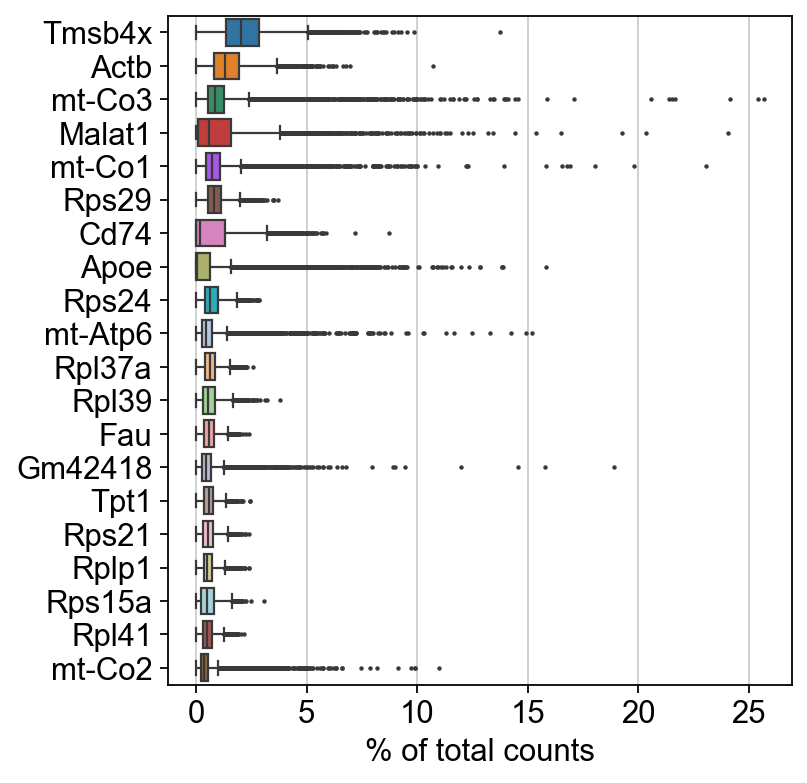

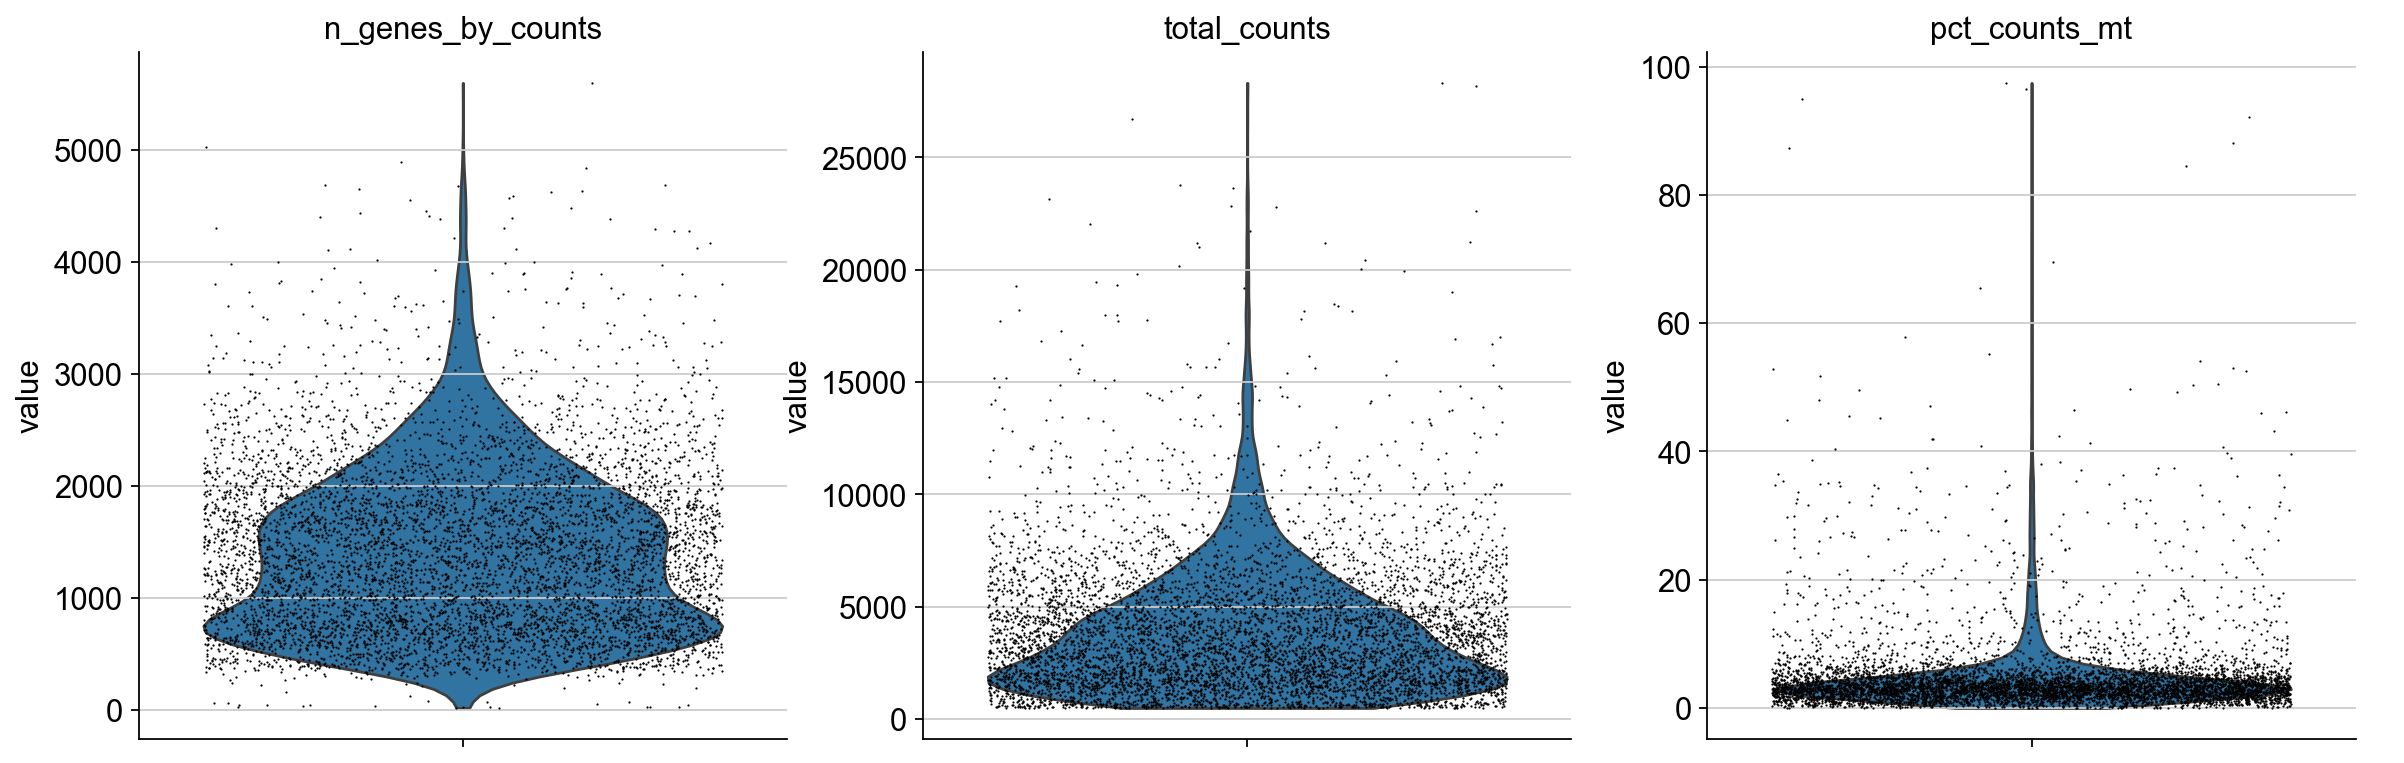

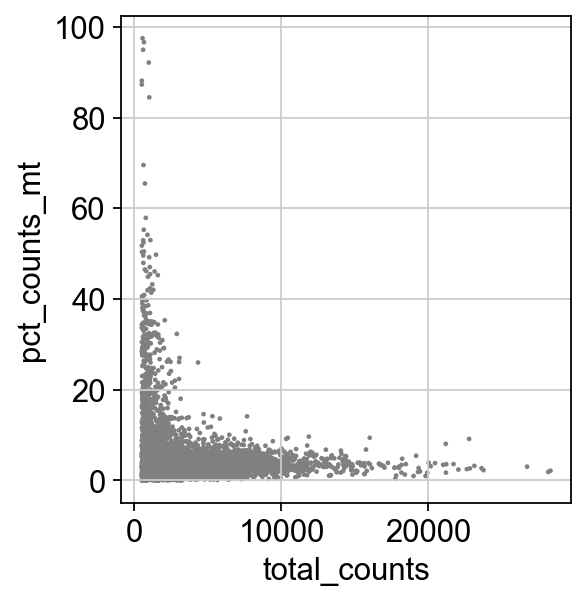

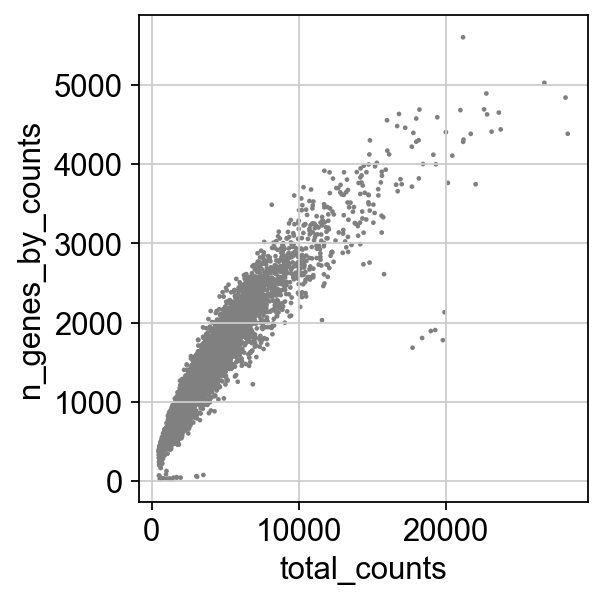

In [ ]:
# Identify mitochondrial genes
adata.var['mt'] = adata.var_names.str.startswith(('mt-', 'MT-'))

# Calculate QC metrics
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], inplace=True)

# Plot highest expressed genes
sc.settings.set_figure_params(dpi=80, facecolor='white')
sc.pl.highest_expr_genes(adata, n_top=20)

# Generate QC plots
sc.pl.violin(
    adata,
    ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
    jitter=0.4,
    multi_panel=True
)
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')


## Step 5: Data Filtering and Transformation

This step focuses on preparing the data for analysis by filtering low-quality features, applying transformations, and identifying key variables:

1. **Data Format Conversion**:
   - If the dataset's gene expression matrix (`adata.X`) is in a sparse format, it is converted to a dense array. This ensures compatibility with downstream operations that require dense matrices.

2. **Gene Filtering**:
   - Genes expressed in fewer than three cells are removed from the dataset. This step eliminates low-quality features that are unlikely to provide meaningful biological insights.

3. **Logarithmic Transformation**:
   - A log transformation is applied to the gene expression data to stabilize variance and reduce the impact of outliers. This transformation is essential for many downstream analyses that assume normalized data distributions.

4. **Highly Variable Gene Identification**:
   - Genes that show significant variability across cells are identified using specified thresholds for mean expression (`min_mean=0.0125`, `max_mean=3`) and dispersion (`min_disp=0.5`). These highly variable genes are critical for downstream dimensionality reduction and clustering.
   - A visualization of highly variable genes is generated to confirm the selection.

5. **Constructing a DataFrame**:
   - The dense gene expression matrix is converted into a pandas DataFrame, with rows representing cells and columns representing genes.
   - A column for the `gender` metadata is added to the DataFrame to facilitate downstream analysis that incorporates cell annotations.


filtered out 15132 genes that are detected in less than 3 cells
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


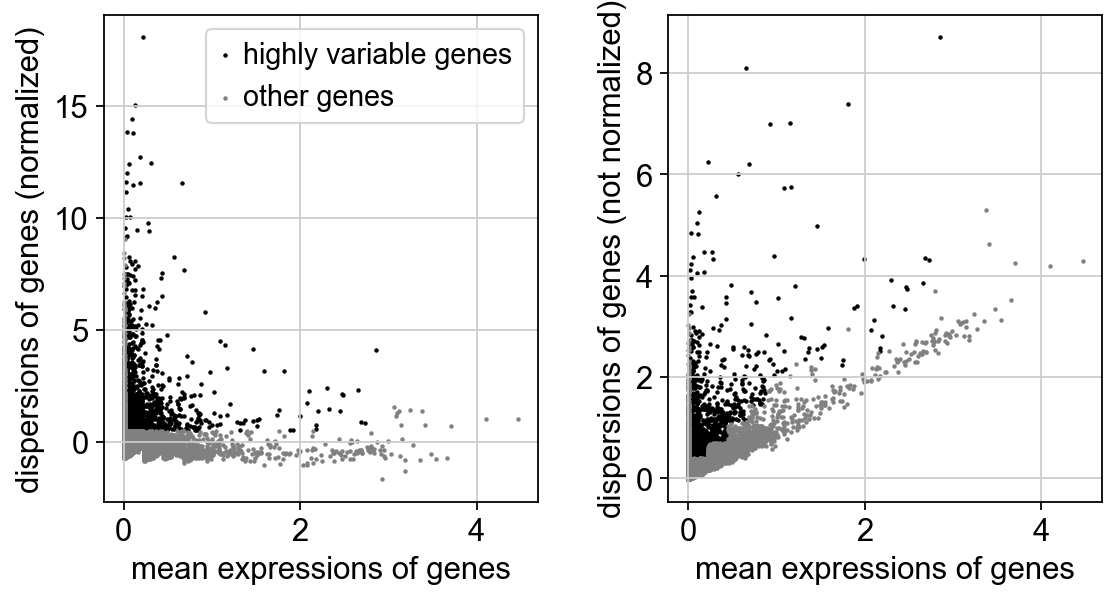

adata.X shape: (6648, 17153)
X_dense shape: (6648, 17153)
adata.obs_names length: 6648
adata.var_names length: 17153


In [ ]:
from scipy.sparse import issparse
import scanpy as sc
import pandas as pd

# First, apply gene filtering
sc.pp.filter_genes(adata, min_cells=3)

# Log-transform the data
sc.pp.log1p(adata)

# Identify highly variable genes and plot
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pl.highly_variable_genes(adata)

# Convert the filtered and transformed data matrix to dense format
if issparse(adata.X):
    X_dense = adata.X.toarray()
else:
    X_dense = adata.X

# Confirm alignment of shapes before creating DataFrame
print(f"adata.X shape: {adata.X.shape}")
print(f"X_dense shape: {X_dense.shape}")
print(f"adata.obs_names length: {len(adata.obs_names)}")
print(f"adata.var_names length: {len(adata.var_names)}")

# Create the DataFrame
rc = pd.DataFrame(X_dense, index=adata.obs_names, columns=adata.var_names)
rc['gender'] = adata.obs['gender'].values

In [ ]:
rc

,Sox17,Mrpl15,Lypla1,Tcea1,Gm16041,Atp6v1h,Rb1cc1,4732440D04Rik,St18,Pcmtd1,...,AC168977.1,CAAA01118383.1,AC132444.1,AC132444.5,Csprs,Vamp7,Tmlhe,CAAA01147332.1,AC149090.1,gender
male_cell_0,0.0,0.000000,0.693147,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,1.098612,male
male_cell_1,0.0,0.000000,0.000000,1.098612,0.0,0.000000,0.693147,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.693147,male
male_cell_2,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,male
male_cell_3,0.0,0.000000,0.000000,0.693147,0.0,0.000000,0.000000,0.0,0.0,0.693147,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.693147,male
male_cell_4,0.0,0.693147,0.000000,0.693147,0.0,0.693147,0.693147,0.0,0.0,0.000000,...,0.0,0.693147,0.0,0.0,0.0,0.000000,0.0,0.0,0.693147,male
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
female_cell_3958,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.693147,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,female
female_cell_3959,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,female
female_cell_3960,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.693147,...,0.0,0.000000,0.0,0.0,0.0,0.693147,0.0,0.0,0.000000,female
female_cell_3961,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.693147,0.0,0.0,0.693147,...,0.0,0.693147,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,female


# Training and Testing Model


This section implements a machine learning pipeline to classify gender based on selected gene expression features. The pipeline is structured into the following key steps:
- Importing required libraries.
- Preparing the dataset by selecting features and encoding the target variable.
- Initializing multiple machine learning models.
- Performing cross-validation to evaluate model performance.
- Computing and visualizing evaluation metrics such as AUROC and AUPRC.

---

## Detailed Steps

### 1. **Import Necessary Libraries**
The code imports essential libraries to handle various tasks:
- **Data Handling**: `pandas`, `numpy` for data manipulation and numerical operations.
- **Model Training**: Includes `LogisticRegression`, `SVC`, `XGBClassifier`, and `RandomForestClassifier`.
- **Preprocessing**: Utilizes `StandardScaler` to standardize features and `LabelEncoder` to encode categorical labels.
- **Cross-Validation**: Uses `KFold` to split data for training and validation.
- **Evaluation**: Implements metrics such as accuracy, precision, recall, F1-score, AUROC, and AUPRC.
- **Visualization**: Leverages `matplotlib` and `seaborn` for performance comparison plots.

---

### 2. **Prepare Dataset**
- **Load Dataset**: 
  Assumes the dataset `rc` is preprocessed or loaded from a file (e.g., `processed_data.csv`).
- **Verify Columns**:
  Prints column names of `rc` to confirm the presence of necessary features and the target variable.
- **Feature Extraction**:
  Selects specific gene expression features (e.g., `'Rpl35', 'Uty', 'Kdm5d'`) for model training.
- **Target Encoding**:
  Encodes the target variable (`gender`) into numerical values using `LabelEncoder` for binary classification tasks.

---

### 3. **Initialize Models**
Four machine learning models are initialized with carefully chosen hyperparameters:
- **Logistic Regression**: Configured with a maximum of 1000 iterations for convergence.
- **Support Vector Classifier (SVC)**: Uses a linear kernel and enables probability estimation.
- **XGBoost Classifier**: Configured with 100 estimators, a learning rate of 0.05, and a maximum depth of 10.
- **Random Forest Classifier**: Configured with a maximum depth of 100 to control overfitting.

---

### 4. **Cross-Validation**
- A 5-fold cross-validation scheme is applied to evaluate each model's performance.
- For each fold:
  1. Data is split into training and validation subsets.
  2. Features are scaled using `StandardScaler` to ensure consistency.
  3. Models are trained on the training data and validated on the validation set.
  4. Predictions are evaluated using the following metrics:
     - **Accuracy**: Measures the overall correctness.
     - **Precision and Recall**: Focus on the positive class's performance.
     - **F1-Score**: Provides a harmonic mean of precision and recall.
     - **AUROC and AUPRC**: Evaluate the quality of probability-based predictions.
- Probability scores are computed using `predict_proba` or `decision_function` if available; if not, appropriate warnings are issued.

---

### 5. **Store Results**
- Metrics are averaged across all folds and stored for each model, providing a summary of performance across multiple iterations.

---

### 6. **Visualize Performance**
- **Bar Plots**:
  - AUROC and AUPRC metrics are visualized for each model using `seaborn.barplot`.
  - These plots allow for a side-by-side comparison of models, aiding in identifying the most effective classifier for the dataset.

---
 


Performing cross-validation for LogisticRegression...

Performing cross-validation for SVC...

Performing cross-validation for XGBClassifier...

Performing cross-validation for RandomForestClassifier...

LogisticRegression Cross-Validation Results:
Accuracy: 0.8988
Precision: 0.8462
Recall: 0.9160
F1_score: 0.8796
Auroc: 0.9682
Auprc: 0.9515

SVC Cross-Validation Results:
Accuracy: 0.9001
Precision: 0.8386
Recall: 0.9325
F1_score: 0.8830
Auroc: 0.9674
Auprc: 0.9490

XGBClassifier Cross-Validation Results:
Accuracy: 0.8943
Precision: 0.8366
Recall: 0.9180
F1_score: 0.8753
Auroc: 0.9674
Auprc: 0.9500

RandomForestClassifier Cross-Validation Results:
Accuracy: 0.8914
Precision: 0.8457
Recall: 0.8946
F1_score: 0.8694
Auroc: 0.9602
Auprc: 0.9329


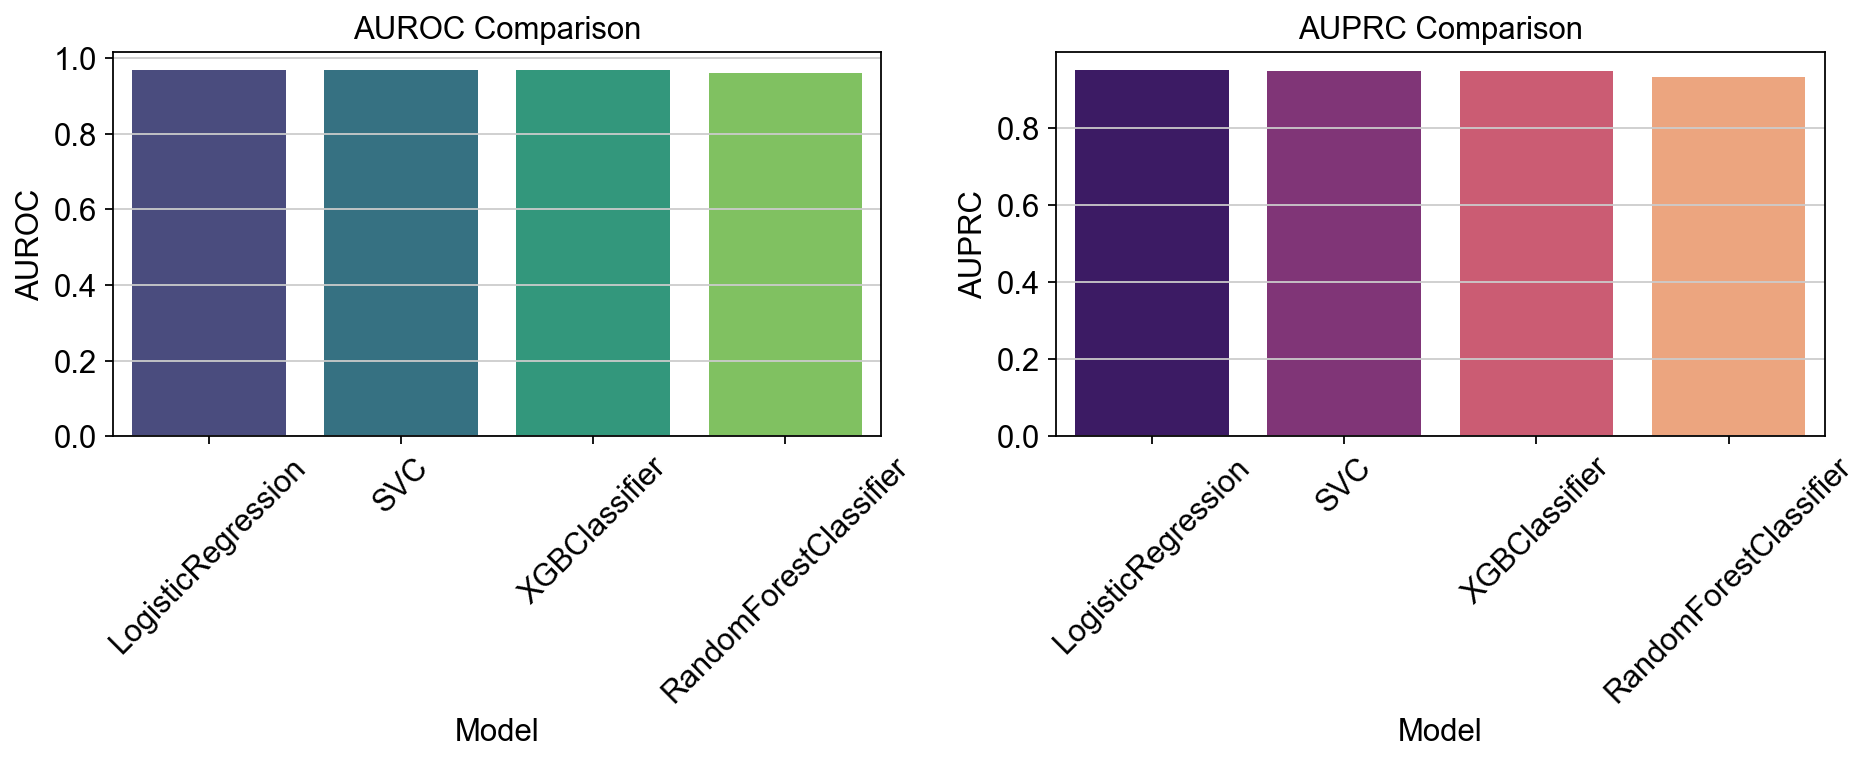

In [ ]:
# Import necessary libraries
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import KFold
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, average_precision_score
)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load your dataset
# Ensure that 'rc' is correctly loaded with the necessary columns
# If 'rc' was created in previous code, you need to save it or run the preprocessing code here
# For example, if you saved 'rc' to a CSV file:
# rc = pd.read_csv('processed_data.csv')

# If 'rc' is already in memory, proceed to the next steps

 

# Extracting the necessary columns for training
columns_to_extract = [
    'Rpl35', 'Rps27rt', 'Rpl9-ps6', 'Rps27', 'Uba52', 'Lars2',
    'Gm42418', 'Uty', 'Kdm5d', 'Eif2s3y', 'Ddx3y', 'Xist'
]
X = rc[columns_to_extract]

# Encode the target variable
le = LabelEncoder()
y = le.fit_transform(rc['gender'])  # Assuming 'gender' is the target variable

# Initialize models
models = [
    LogisticRegression(max_iter=1000, random_state=551),
    SVC(kernel='linear', probability=True, random_state=551),
    XGBClassifier(
        eval_metric='logloss',
        n_estimators=100,
        learning_rate=0.05,
        max_depth=10,
        random_state=551
    ),
    RandomForestClassifier(max_depth=100, random_state=41)
]

# Cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=551)
cv_results = {}

for model in models:
    model_name = type(model).__name__
    print(f"\nPerforming cross-validation for {model_name}...")
    
    metrics = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1_score': [],
        'auroc': [],
        'auprc': []
    }
    
    for train_index, val_index in kf.split(X):
        # Split data into training and validation sets
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y[train_index], y[val_index]  # Index y as a NumPy array
        
        # Scale data within each fold
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_val_scaled = scaler.transform(X_val)
        
        # Train model
        model.fit(X_train_scaled, y_train)
        
        # Make predictions
        y_pred = model.predict(X_val_scaled)
        
        # Evaluate metrics
        metrics['accuracy'].append(accuracy_score(y_val, y_pred))
        metrics['precision'].append(precision_score(y_val, y_pred))
        metrics['recall'].append(recall_score(y_val, y_pred))
        metrics['f1_score'].append(f1_score(y_val, y_pred))
        
        # Compute predicted probabilities for AUROC and AUPRC
        if hasattr(model, "predict_proba"):
            y_proba = model.predict_proba(X_val_scaled)[:, 1]
        elif hasattr(model, "decision_function"):
            # For models like SVM without predict_proba but with decision_function
            y_scores = model.decision_function(X_val_scaled)
            y_proba = (y_scores - y_scores.min()) / (y_scores.max() - y_scores.min())
        else:
            # If neither is available, skip AUROC and AUPRC computation
            y_proba = None
            print(f"Model {model_name} does not support probability estimates.")
        
        if y_proba is not None:
            # Evaluate AUROC and AUPRC
            metrics['auroc'].append(roc_auc_score(y_val, y_proba))
            metrics['auprc'].append(average_precision_score(y_val, y_proba))
        
    # Store average metrics for the model
    cv_results[model_name] = {metric: np.mean(values) for metric, values in metrics.items()}
    
# Display cross-validation results for each model
for model_name, metrics in cv_results.items():
    print(f"\n{model_name} Cross-Validation Results:")
    for metric, value in metrics.items():
        print(f"{metric.capitalize()}: {value:.4f}")
        

# Prepare data for plotting
metrics_to_plot = ['auroc', 'auprc']
plot_data = []

# Reshape data for Seaborn's new API
for model_name, metrics in cv_results.items():
    for metric in metrics_to_plot:
        plot_data.append({
            'Model': model_name,
            'Metric Value': metrics.get(metric, 0),
            'Metric Type': metric.upper()
        })

plot_df = pd.DataFrame(plot_data)

# Create bar plots for AUROC and AUPRC
plt.figure(figsize=(12, 5))

# AUROC bar plot
plt.subplot(1, 2, 1)
sns.barplot(data=plot_df[plot_df['Metric Type'] == 'AUROC'],
            x='Model',
            y='Metric Value',
            hue='Model',
            legend=False,
            palette='viridis')
plt.title('AUROC Comparison')
plt.xlabel('Model')
plt.ylabel('AUROC')
plt.xticks(rotation=45)

# AUPRC bar plot
plt.subplot(1, 2, 2)
sns.barplot(data=plot_df[plot_df['Metric Type'] == 'AUPRC'],
            x='Model',
            y='Metric Value',
            hue='Model',
            legend=False,
            palette='magma')
plt.title('AUPRC Comparison')
plt.xlabel('Model')
plt.ylabel('AUPRC')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()
